In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
params = {'image.cmap': "Set2"}
matplotlib.rcParams.update(params)
import numpy as np
import floatpy.readers.padeops_reader as por
import scripts.statistics as stats

fs = 12
xdir = 0
ydir = 1
xdir = 2

def get_q(reader,qname):
    u = reader.readData(qname);
    u = np.squeeze(u);
    ubar = np.mean(np.mean(u,axis=1),axis=0);
    uprime2D = np.squeeze(u-ubar)
    return u,ubar,uprime2D

def get_qf(reader,qname):#Favre average
    r,u = reader.readData(('rho',qname));
    u = np.squeeze(u);
    r = np.squeeze(r);  
    rbar   = np.mean(np.mean(r))
    utilde = np.mean(np.mean(r*u))/rbar;
    upprime2D = np.squeeze(u-utilde)
    return u,utilde,upprime2D


In [4]:
directory = "/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/256x384x128/"
filename_prefix = directory+'shearlayer_'
reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))

Nx,Ny,Nz,Lx,Ly,Lz,dx,dy,dz,kx,kz = stats.domain(reader,verbose=1)
steps = sorted(reader.steps)
print("Steps: {}".format(reader.steps))

Domain size: 172.0 x 257.328125 x 82.0
Grid size: 256 x 384 x 128
Grid res: 0.671875 x 0.671875 x 0.640625
Steps: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22)


Time: 1900.0


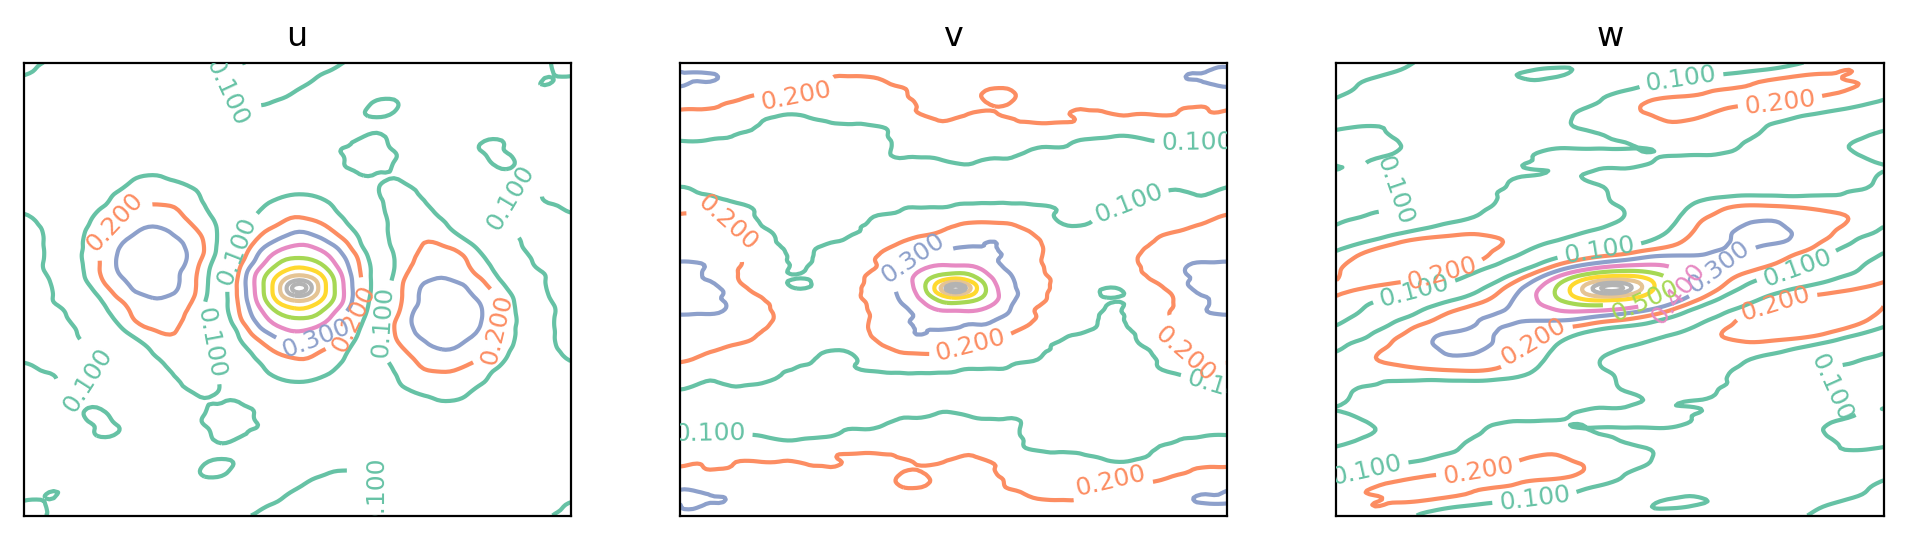

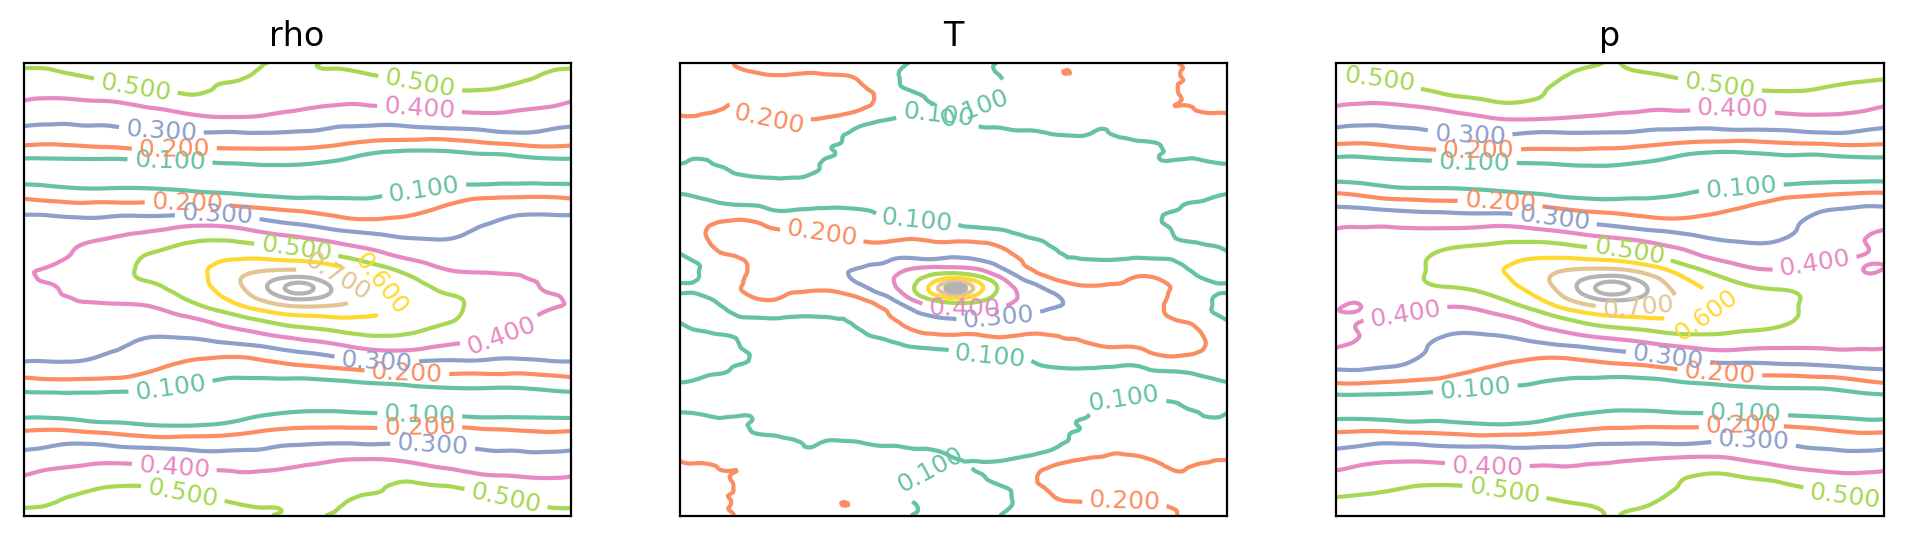

In [6]:
# Autocorrelation
def autocorr(uprime2D):
    uhat = np.fft.fftshift(np.fft.fft2(uprime2D))
    R_fft = np.square(np.abs(uhat))
    R = np.abs(np.fft.fftshift(np.fft.ifft2(R_fft)))
    return R/R.max()

def plot_autocorr(reader,plist,yslice):
    reader.sub_domain = (0,yslice,0), (reader.domain_size[0]-1, yslice, reader.domain_size[2]-1)
    
    # Plotting options
    fig, ax = plt.subplots(1,3, figsize=(12,3), dpi=200)
    levels = np.arange(0.,1.,0.1)

    i = 0; #ax counter
    for primitive in plist:
        u,U,uprime2D = get_qf(reader,primitive)
        Rii = autocorr(uprime2D)
        cont = ax[i].contour(Rii,levels=levels)
        ax[i].clabel(cont, inline=1, fontsize=0.75*fs)
        ax[i].set_xticks([])
        ax[i].set_yticks([]) 
        ax[i].set_title(primitive)
        i+=1


yslice = Ny/2
reader.step = 19
print("Time: {}".format(reader.time))
plot_autocorr(reader,('u','v','w'),yslice)
plot_autocorr(reader,('rho','T','p'),yslice)


Time: 1900.0
(256, 128)
0
(256, 128)
0
(256, 128)
0
(256, 128)
0
(256, 128)
0
(256, 128)
0


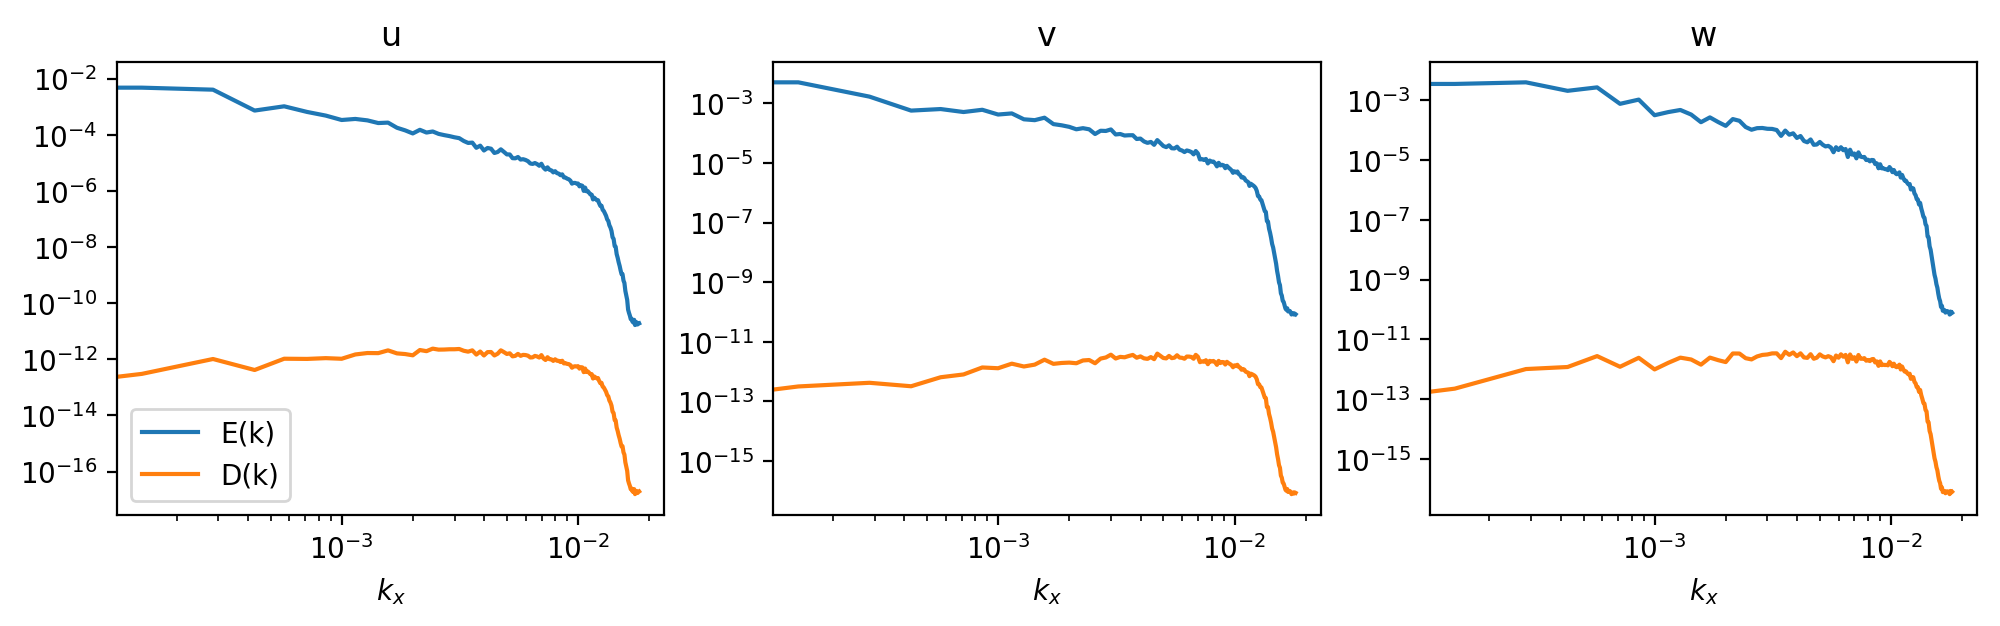

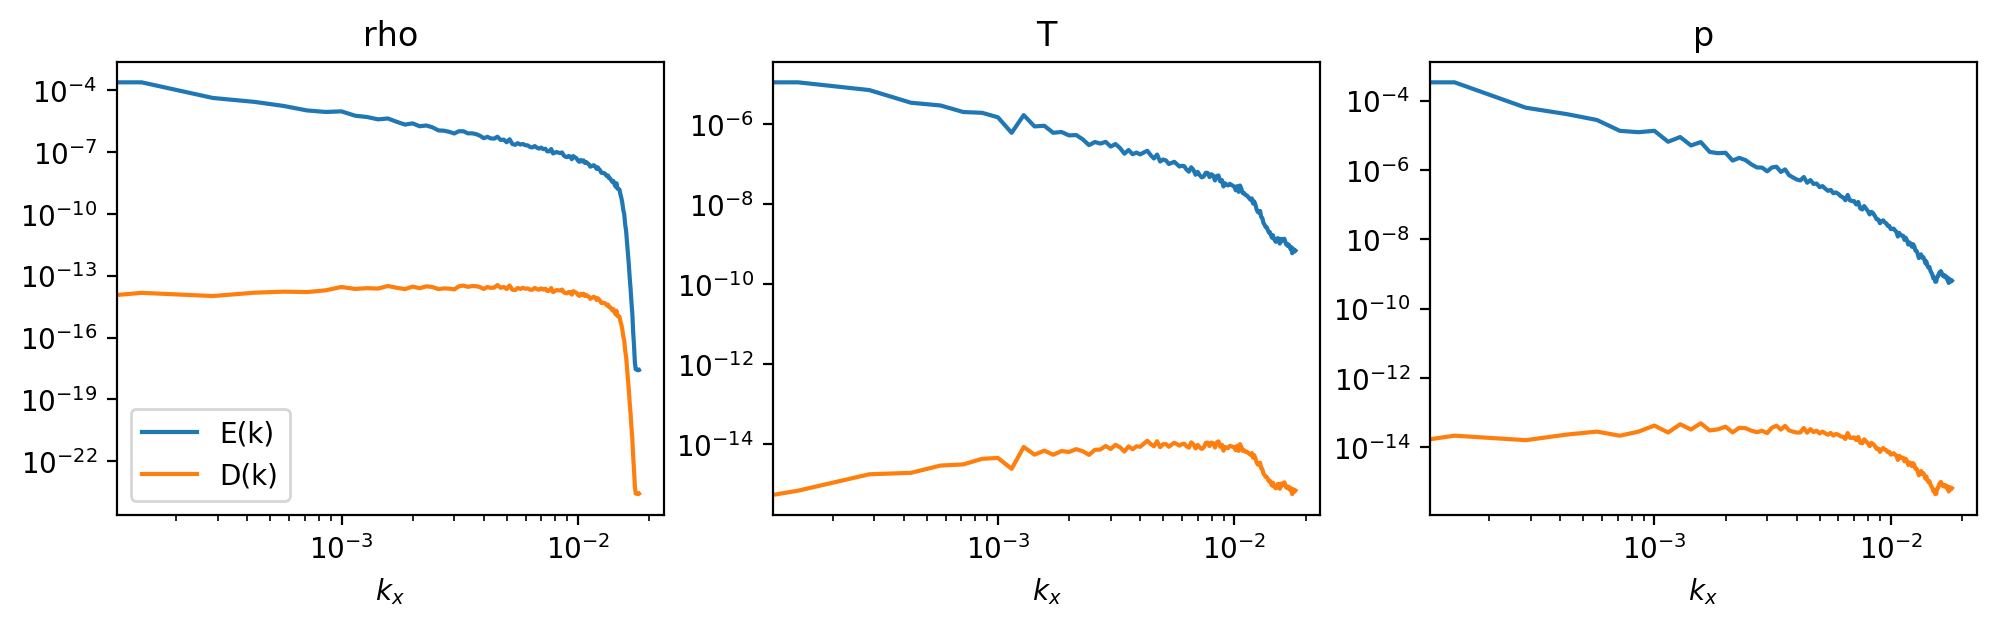

In [12]:
# Energy spectra
def Eii(uprime,k_axis):
    uhat = 1./Nx * np.fft.fft(uprime,axis=k_axis)
    return 2.* np.mean( np.square(np.abs(uhat)),1)

def energy_spectra(reader,plist,yslice):
    reader.sub_domain = (0,yslice,0), (reader.domain_size[0]-1, yslice, reader.domain_size[2]-1)
    idx = range(Nx/2)
    fig, ax = plt.subplots(1,3, figsize=(12,3), dpi=200)
    Re = 640
    nu = 1./Re
    
    i = 0   
    for primitive in plist:
        u,U,uprime2D = get_qf(reader,primitive)
        Espec = Eii(uprime2D,k_axis=0)
        E = Espec[idx]
        D = 2*nu*E*kx**2;
        ax[i].loglog(kx,E,label='E(k)')
        ax[i].loglog(kx,D,label='D(k)')
        ax[i].set_xlabel('$k_x$')
        ax[i].set_title(primitive)
        i+=1
    ax[0].legend()
    
yslice = Ny/2
reader.step = 19
print("Time: {}".format(reader.time))
energy_spectra(reader,('u','v','w'),yslice)
energy_spectra(reader,('rho','T','p'),yslice)

Time: 1000.0


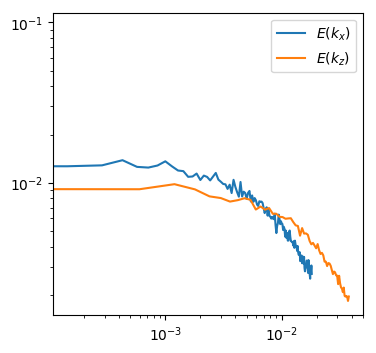

In [6]:
# Enstrophy spectrum at midplane. See enstrophy.py
def plot_enstrophy_spectra(step):
    reader.step = step;
    print("Time: {}".format(reader.time))

    fig = plt.figure(figsize=(4,4), dpi=100)
    dat = np.fromfile(filename_prefix + "%04d"%step + "_enstrophy_spectrum_x.dat",dtype=float,count=-1,sep='\n')
    plt.loglog(kx,dat[range(Nx/2)],label='$E(k_x)$')
    dat = np.fromfile(filename_prefix + "%04d"%step + "_enstrophy_spectrum_z.dat",dtype=float,count=-1,sep='\n')
    plt.loglog(kz,dat[range(Nz/2)],label='$E(k_z)$')
    plt.legend()

plot_enstrophy_spectra(step=10)
